In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, r2_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, accuracy_score, recall_score
import itertools
import joblib
import json

In [4]:
model_info = {
    'model_name': 'Cost Effective Decision Tree (Controller)',
    'training_file': 'MLM_Decision_Tree_Controller.ipynb',
    'file_name': '../models/model_dtc_controller.pkl',
    'scaler_file': '../models/scaler_dtc_controller.pkl',
    'prepared_by': 'Digital Khalid',
    'library': 'Scikit-Learn',
    'classifier': 'Decision Tree Classifier',
    'normalization': 'Standard Scaler (Z-Score)',
    'data_file': '../datasets/mawi_flows.csv',
    'features': ['src_port', 'dst_port', 'protocol', 'pkt_size_1', 'pkt_size_2', 'pkt_size_3', 'pkt_size_4', 'pkt_size_5', 'pkt_size_6', 'pkt_size_7', '7_pkt_size', '7_pkt_min_size', '7_pkt_max_size', '7_pkt_mean_size'],
    'target': ['elephant'],
}

In [5]:
# Save model information as json file
with open(f'model_info_{model_info["model_name"]}.json', "w") as outfile:
    json.dump(model_info, outfile)

In [6]:
# Read data file
input_file = model_info['data_file']
input_file
flows = pd.read_csv(input_file)

In [7]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [8]:
print(f'features (X)\n{X}')

features (X)
         src_port  dst_port  protocol  pkt_size_1  pkt_size_2  pkt_size_3  \
0            1999     54524         6          66          66          66   
1           50005      3479        17         183         191         196   
2           44734       443         6          54          54          54   
3           43332      3128         6          54           0           0   
4           61554       443         6          85          54           0   
...           ...       ...       ...         ...         ...         ...   
1518385     48152      3128         6          58           0           0   
1518386      7528        80         6          58           0           0   
1518387        80     12256         6          66          66           0   
1518388     44843      2375         6          54           0           0   
1518389     50355     43527         6          58           0           0   

         pkt_size_4  pkt_size_5  pkt_size_6  pkt_size_7  7_pkt

In [9]:
print(f'features (y)\n{y}')

features (y)
         elephant
0               0
1               1
2               0
3               0
4               0
...           ...
1518385         0
1518386         0
1518387         0
1518388         0
1518389         0

[1518390 rows x 1 columns]


In [10]:
# Data Normalization
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_norm = scaler.fit_transform(X)
X_norm

array([[-1.48137583,  2.11086118, -0.33874667, ..., -0.10096778,
        -0.1489126 , -0.15483547],
       [ 0.75371663, -0.59077602,  2.95205852, ...,  1.20182975,
         0.33464997,  0.81252101],
       [ 0.50830622, -0.75146112, -0.33874667, ..., -0.25129057,
        -0.19354915, -0.25602843],
       ...,
       [-1.5707218 , -0.12623944, -0.33874667, ..., -0.10096778,
        -0.1489126 , -0.15483547],
       [ 0.51338111, -0.64920697, -0.33874667, ..., -0.25129057,
        -0.19354915, -0.25602843],
       [ 0.77001214,  1.52882759, -0.33874667, ..., -0.20118297,
        -0.1786703 , -0.22229744]])

In [11]:
joblib.dump(scaler, model_info['scaler_file'])

['../models/scaler_dtc_controller.pkl']

In [12]:
flows

,start_time,end_time,src_ip,dst_ip,protocol,src_port,dst_port,pkt_size_1,pkt_size_2,pkt_size_3,...,7_pkt_size,7_pkt_max_iat,7_pkt_mean_iat,7_pkt_duration,flow_size,flow_pkt_count,flow_max_iat,flow_mean_iat,flow_duration,elephant
0,1688187600,1688187685,149.40.55.233,203.115.138.41,6,1999,54524,66,66,66,...,462,19,12.4375,44,792,12,19,6.982422e+00,85,0
1,1688187600,1688187692,202.11.248.134,52.113.75.222,17,50005,3479,183,191,196,...,1265,0,0.0000,0,841789,4697,1,4.547474e-13,92,1
2,1688187600,1688187606,45.100.248.16,202.249.92.162,6,44734,443,54,54,54,...,216,4,2.5000,6,216,4,4,2.500000e+00,6,0
3,1688187600,1688187600,38.88.114.91,163.37.23.124,6,43332,3128,54,0,0,...,54,0,0.0000,0,54,1,0,0.000000e+00,0,0
4,1688187600,1688187600,163.37.117.124,38.186.128.63,6,61554,443,85,54,0,...,139,0,0.0000,0,139,2,0,0.000000e+00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518385,1688187692,1688187692,45.197.187.47,163.37.128.119,6,48152,3128,58,0,0,...,58,0,0.0000,0,58,1,0,0.000000e+00,0,0
1518386,1688187692,1688187692,167.248.189.103,163.37.93.253,6,7528,80,58,0,0,...,58,0,0.0000,0,58,1,0,0.000000e+00,0,0
1518387,1688187692,1688187692,202.249.93.185,46.25.179.131,6,80,12256,66,66,0,...,132,0,0.0000,0,132,2,0,0.000000e+00,0,0
1518388,1688187692,1688187692,146.64.20.95,150.161.104.40,6,44843,2375,54,0,0,...,54,0,0.0000,0,54,1,0,0.000000e+00,0,0


In [13]:
flows['elephant'].value_counts()*100 / flows.shape[0]

elephant
0    99.887578
1     0.112422
Name: count, dtype: float64

In [61]:
flows[flows['pkt_size_7'] > 0]

,start_time,end_time,src_ip,dst_ip,protocol,src_port,dst_port,pkt_size_1,pkt_size_2,pkt_size_3,...,7_pkt_size,7_pkt_max_iat,7_pkt_mean_iat,7_pkt_duration,flow_size,flow_pkt_count,flow_max_iat,flow_mean_iat,flow_duration,elephant
0,1688187600,1688187685,149.40.55.233,203.115.138.41,6,1999,54524,66,66,66,...,462,19,12.4375,44,792,12,19,6.982422e+00,85,0
1,1688187600,1688187692,202.11.248.134,52.113.75.222,17,50005,3479,183,191,196,...,1265,0,0.0000,0,841789,4697,1,4.547474e-13,92,1
5,1688187600,1688187613,103.218.167.178,131.241.192.55,6,443,54447,1063,1126,590,...,6747,0,0.0000,0,26214,76,10,6.250315e-01,13,0
6,1688187600,1688187601,143.202.163.200,202.249.92.240,6,58884,8087,54,67,67,...,430,1,0.2500,1,430,7,1,2.500000e-01,1,0
8,1688187600,1688187620,160.240.216.161,150.161.6.133,6,47714,80,66,66,66,...,462,0,0.0000,0,4429710,67041,1,5.000000e-01,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517133,1688187692,1688187692,142.250.245.86,150.161.48.224,6,443,59994,74,66,1466,...,5795,0,0.0000,0,5795,7,0,0.000000e+00,0,0
1517383,1688187692,1688187692,172.33.17.149,163.37.149.191,17,443,63109,1292,1292,858,...,3958,0,0.0000,0,3958,7,0,0.000000e+00,0,0
1517631,1688187692,1688187692,163.37.238.147,8.1.60.254,6,60091,80,66,54,197,...,533,0,0.0000,0,1073,17,0,0.000000e+00,0,0
1517658,1688187692,1688187692,142.251.68.46,150.161.250.194,17,443,53984,1292,1292,854,...,5162,0,0.0000,0,5369,10,0,0.000000e+00,0,0


### Grid Search CV to Find Best Hyperparameters

In [20]:
# define model
model = DecisionTreeClassifier()

In [52]:
# define grid
# balance = [{0:1,1:1000}, {0:1,1:500}, {0:1,1:250}]
class_weight = [{0:1,1:39}, {0:1,1:25}]
max_depth = [3, 5, 10]
min_samples_split = [3, 5, 10]
criterion = ['gini', 'entropy']
splitter = ['best']
# splitter = ['best', 'random']

param_grid = {
    'class_weight': class_weight,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'criterion': criterion,
    'splitter': splitter,
}

In [56]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define the scoring metric you want to use
scoring_metric = make_scorer(f1_score)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-3, cv=cv, scoring='accuracy', verbose=3)

In [57]:
# execute the grid search
grid_result = grid.fit(X_norm, y)

Fitting 30 folds for each of 36 candidates, totalling 1080 fits
[CV 13/30] END class_weight={0: 1, 1: 25}, criterion=gini, max_depth=10, min_samples_split=5, splitter=best;, score=0.911 total time=   0.4s
[CV 14/30] END class_weight={0: 1, 1: 25}, criterion=gini, max_depth=10, min_samples_split=5, splitter=best;, score=0.908 total time=   0.4s
[CV 27/30] END class_weight={0: 1, 1: 25}, criterion=gini, max_depth=10, min_samples_split=5, splitter=best;, score=0.891 total time=   0.5s
[CV 28/30] END class_weight={0: 1, 1: 25}, criterion=gini, max_depth=10, min_samples_split=5, splitter=best;, score=0.902 total time=   0.5s
[CV 11/30] END class_weight={0: 1, 1: 25}, criterion=gini, max_depth=10, min_samples_split=10, splitter=best;, score=0.911 total time=   0.4s
[CV 12/30] END class_weight={0: 1, 1: 25}, criterion=gini, max_depth=10, min_samples_split=10, splitter=best;, score=0.904 total time=   0.4s
[CV 25/30] END class_weight={0: 1, 1: 25}, criterion=gini, max_depth=10, min_samples_spl

In [58]:
# report the best configuration
print(f'\nBest Score: {grid_result.best_score_:.3f} achieved using following parameters: \n{grid_result.best_params_}\n')

# report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


Best Score: 0.927 achieved using following parameters: 
{'class_weight': {0: 1, 1: 25}, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3, 'splitter': 'best'}



### Cost Effective Decision Tree (Using best hyperparameters)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [54]:
best_param_grid = {
    'class_weight': {0:1, 1:1200},
    'max_depth': 10,
    'min_samples_split': 3,
    'criterion': 'gini',
    'splitter': 'best',
}

# define model
model = DecisionTreeClassifier(**best_param_grid)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [55]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'False Positive Rate: {fpr[1]}\nTrue Positive Rate: {tpr[1]}\nROC_AUC: {roc_auc}')

Precision: 0.5248038345760191
Recall: 0.9789067536631452
F1 Score: 0.5418974463518348
Accuracy: 0.9788908266113099
False Positive Rate: 0.02110920930134425
True Positive Rate: 0.9789227166276346
ROC_AUC: 0.9789067536631452


In [12]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
scores = cross_val_score(model, X_norm, y, scoring='roc_auc', cv=cv, n_jobs=-2)
np.mean(scores)

### Save Model File

In [21]:
joblib.dump(model, model_info['file_name'])

['../models/model_dtc_controller.pkl']

### Load Model File (Further Evaluation)

In [56]:
model = joblib.load(model_info['file_name'])

In [57]:
scaler = joblib.load(model_info['scaler_file'])

In [58]:
model.feature_importances_

array([1.35014713e-02, 1.84418781e-02, 1.44383131e-02, 1.41380710e-05,
       2.28803236e-03, 4.13145226e-03, 2.09896372e-04, 1.28039914e-03,
       3.12379108e-06, 5.18178932e-02, 8.90784626e-01, 0.00000000e+00,
       9.49337881e-04, 2.13943797e-03])

In [6]:
model_info['features']

['src_port',
 'dst_port',
 'protocol',
 'pkt_size_1',
 'pkt_size_2',
 'pkt_size_3',
 'pkt_size_4',
 'pkt_size_5',
 'pkt_size_6',
 'pkt_size_7',
 '7_pkt_size',
 '7_pkt_max_iat',
 '7_pkt_mean_iat',
 '7_pkt_duration']

In [78]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [79]:
X_norm = scaler.transform(X)

In [80]:
predictions = model.predict(X_norm)

In [81]:
predictions

array([1, 1, 1, ..., 1, 0, 0])

In [82]:
predictions = pd.Series(predictions, index=X.index)
predictions

0         1
1         1
2         1
3         0
4         1
         ..
238413    1
238414    0
238415    1
238416    0
238417    0
Length: 238418, dtype: int64

In [83]:
flows['packet_count']

0          8463
1          4697
2             2
3            76
4         67041
          ...  
238413        1
238414        1
238415        2
238416        1
238417        1
Name: packet_count, Length: 238418, dtype: int64

In [84]:
pred_flows = pd.concat([X, y, predictions], axis=1)
pred_flows

,src_port,dst_port,protocol,first_pkt_size,actual_elephant,0
0,0,0,1,70,1,1
1,50005,3479,17,183,1,1
2,61554,443,6,85,0,1
3,443,54447,6,1063,0,0
4,47714,80,6,66,1,1
...,...,...,...,...,...,...
238413,445,18982,6,62,0,1
238414,19770,22022,6,74,0,0
238415,443,58289,17,1392,0,1
238416,64216,443,6,66,0,0


In [85]:
pred_flows.rename(columns={0: 'predicted_elephant'}, inplace=True)

In [86]:
pred_flows

,src_port,dst_port,protocol,first_pkt_size,actual_elephant,predicted_elephant
0,0,0,1,70,1,1
1,50005,3479,17,183,1,1
2,61554,443,6,85,0,1
3,443,54447,6,1063,0,0
4,47714,80,6,66,1,1
...,...,...,...,...,...,...
238413,445,18982,6,62,0,1
238414,19770,22022,6,74,0,0
238415,443,58289,17,1392,0,1
238416,64216,443,6,66,0,0


In [87]:
pred_flows.query('actual_elephant != predicted_elephant')

,src_port,dst_port,protocol,first_pkt_size,actual_elephant,predicted_elephant
2,61554,443,6,85,0,1
10,0,0,1,70,0,1
11,0,0,1,70,0,1
15,60320,443,6,85,0,1
17,443,55879,6,1514,0,1
...,...,...,...,...,...,...
238397,443,51946,17,1292,0,1
238398,443,63096,17,1292,0,1
238399,443,62087,17,1292,0,1
238413,445,18982,6,62,0,1


In [88]:
pred_flows.query('actual_elephant==0 & predicted_elephant==1')

,src_port,dst_port,protocol,first_pkt_size,actual_elephant,predicted_elephant
2,61554,443,6,85,0,1
10,0,0,1,70,0,1
11,0,0,1,70,0,1
15,60320,443,6,85,0,1
17,443,55879,6,1514,0,1
...,...,...,...,...,...,...
238397,443,51946,17,1292,0,1
238398,443,63096,17,1292,0,1
238399,443,62087,17,1292,0,1
238413,445,18982,6,62,0,1


In [89]:
# pd.set_option('display.max_rows', None)
pred_flows[pred_flows['predicted_elephant'] == 0].value_counts()

src_port  dst_port  protocol  first_pkt_size  actual_elephant  predicted_elephant
0         0         1         98              0                0                     19684
5100      5060      17        457             0                0                      8599
                              456             0                0                      7308
500       500       17        246             0                0                      5789
5100      5060      17        458             0                0                      5342
                                                                                     ...  
443       13392     6         58              0                0                         1
          13363     6         58              0                0                         1
          13301     6         58              0                0                         1
          13276     6         58              0                0                         1
65534   

In [113]:
pred_flows.query('src_port==0 & dst_port==0 & actual_elephant==0 & predicted_elephant==0').value_counts()

src_port  dst_port  protocol  first_pkt_size  actual_elephant  predicted_elephant
0         0         1         98              0                0                     19684
                              94              0                0                      2210
                              74              0                0                      1660
                              82              0                0                       703
                              78              0                0                       538
                                                                                     ...  
                              300             0                0                         1
                              343             0                0                         1
                              344             0                0                         1
                              370             0                0                         1
        

In [100]:
pred_flows.query('protocol==17 & actual_elephant==0 & predicted_elephant==1').value_counts()

src_port  dst_port  protocol  first_pkt_size  actual_elephant  predicted_elephant
51799     5060      17        370             0                1                     104
30321     123       17        234             0                1                      89
54588     11900     17        139             0                1                      75
53614     4498      17        1290            0                1                      70
54438     5060      17        420             0                1                      65
                                                                                    ... 
443       64267     17        246             0                1                       1
          64251     17        1292            0                1                       1
          64248     17        1292            0                1                       1
          64242     17        1292            0                1                       1
64340     63853     17      

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [11]:
y_pred = model.predict(X_test)

In [12]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'False Positive Rate: {fpr[1]}\nTrue Positive Rate: {tpr[1]}\nROC_AUC: {roc_auc}')

Precision: 0.5213461730186191
Recall: 0.987054723028572
F1 Score: 0.5355672395614373
Accuracy: 0.978754904790336
False Positive Rate: 0.021260924313226497
True Positive Rate: 0.9953703703703703
ROC_AUC: 0.9870547230285719


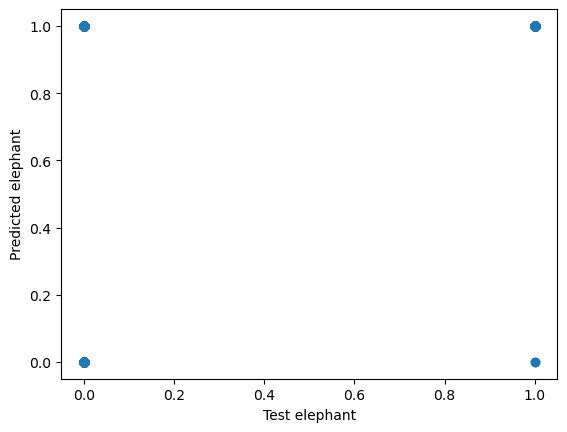

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel('Test ' + target[0])
ax.set_ylabel('Predicted ' + target[0])
ax.scatter(y_test, y_pred)

(array([443822.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  10071.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

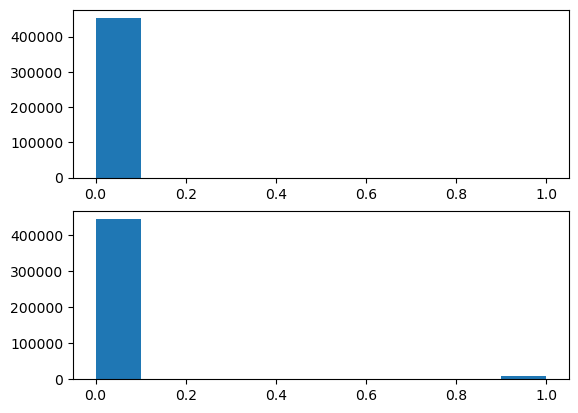

In [14]:
fig, ax = plt.subplots(2)
ax[0].hist(y_test)
ax[1].hist(y_pred)

In [15]:
predictions = pd.DataFrame(y_pred)
testset = pd.DataFrame(y_test)

# get the set of distinct classes
labels_pred = predictions[0].unique()
labels_test = testset.actual_elephant.unique()

# get the count of each class
sizes_pred = predictions[0].value_counts().values
sizes_test = testset.actual_elephant.value_counts().values

font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 100}

matplotlib.rc('font', **font)

# plot the class value counts
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(100, 100))
plt.subplots_adjust(bottom=0.1, right=1, top=0.5)

ax[0].pie(sizes_pred, labels=labels_pred, autopct='%1.3f%%')
ax[0].set_title('Predicted Elephant Flows Counts')

ax[1].pie(sizes_test, labels=labels_test, autopct='%1.3f%%')
ax[1].set_title('Test Elephant Flows Counts')

plt.show()

AttributeError: 'DataFrame' object has no attribute 'actual_elephant'

### Confusion Matrix

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[   207    220]
 [   167 379004]]


Confusion matrix, without normalization
[[   418      9]
 [  8004 371167]]


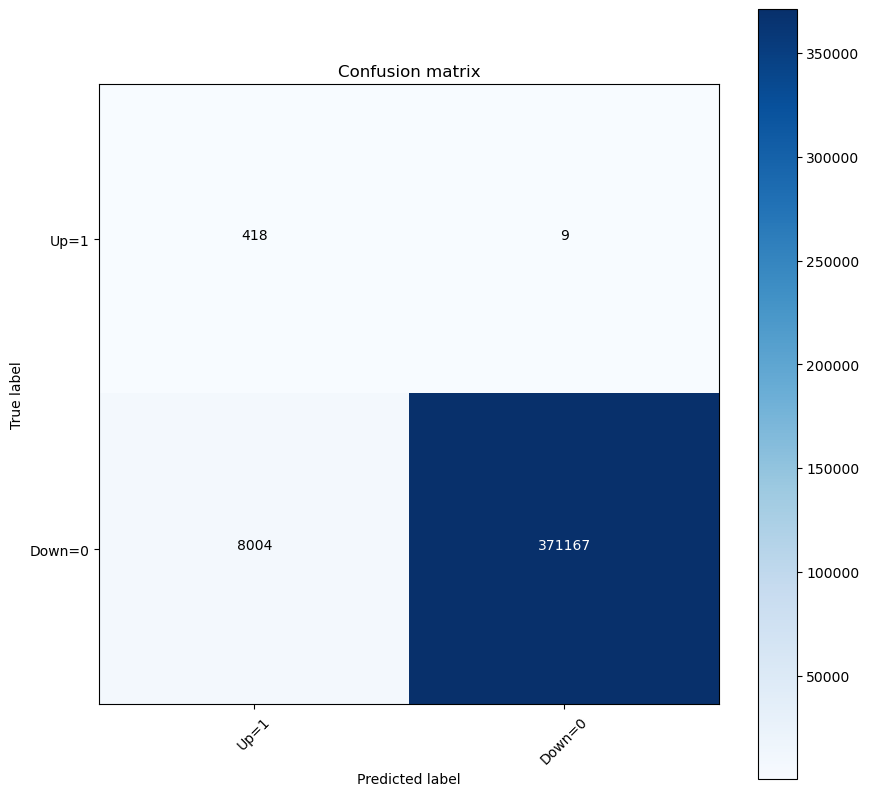

In [59]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['Up=1','Down=0'], normalize=False, title='Confusion matrix')


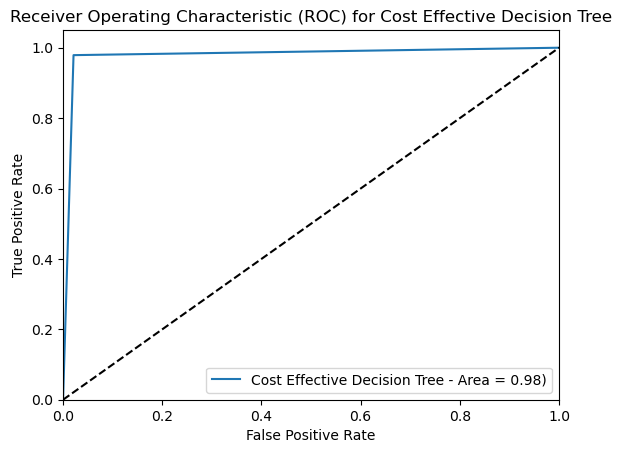

In [60]:
# Plot ROC curve
plt.plot(fpr, tpr, label=f"Cost Effective Decision Tree - Area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) for Cost Effective Decision Tree')
plt.legend(loc="lower right")

# Save the ROC curve plot as an image
# plt.savefig(f"ROC_Curve_CEDT.png")

# Show the ROC curve plot
plt.show()